## HISTOGRAM EQUALIZATION- Equalizing the Contrast
Step 1: Load the image and display the sample image

In [5]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


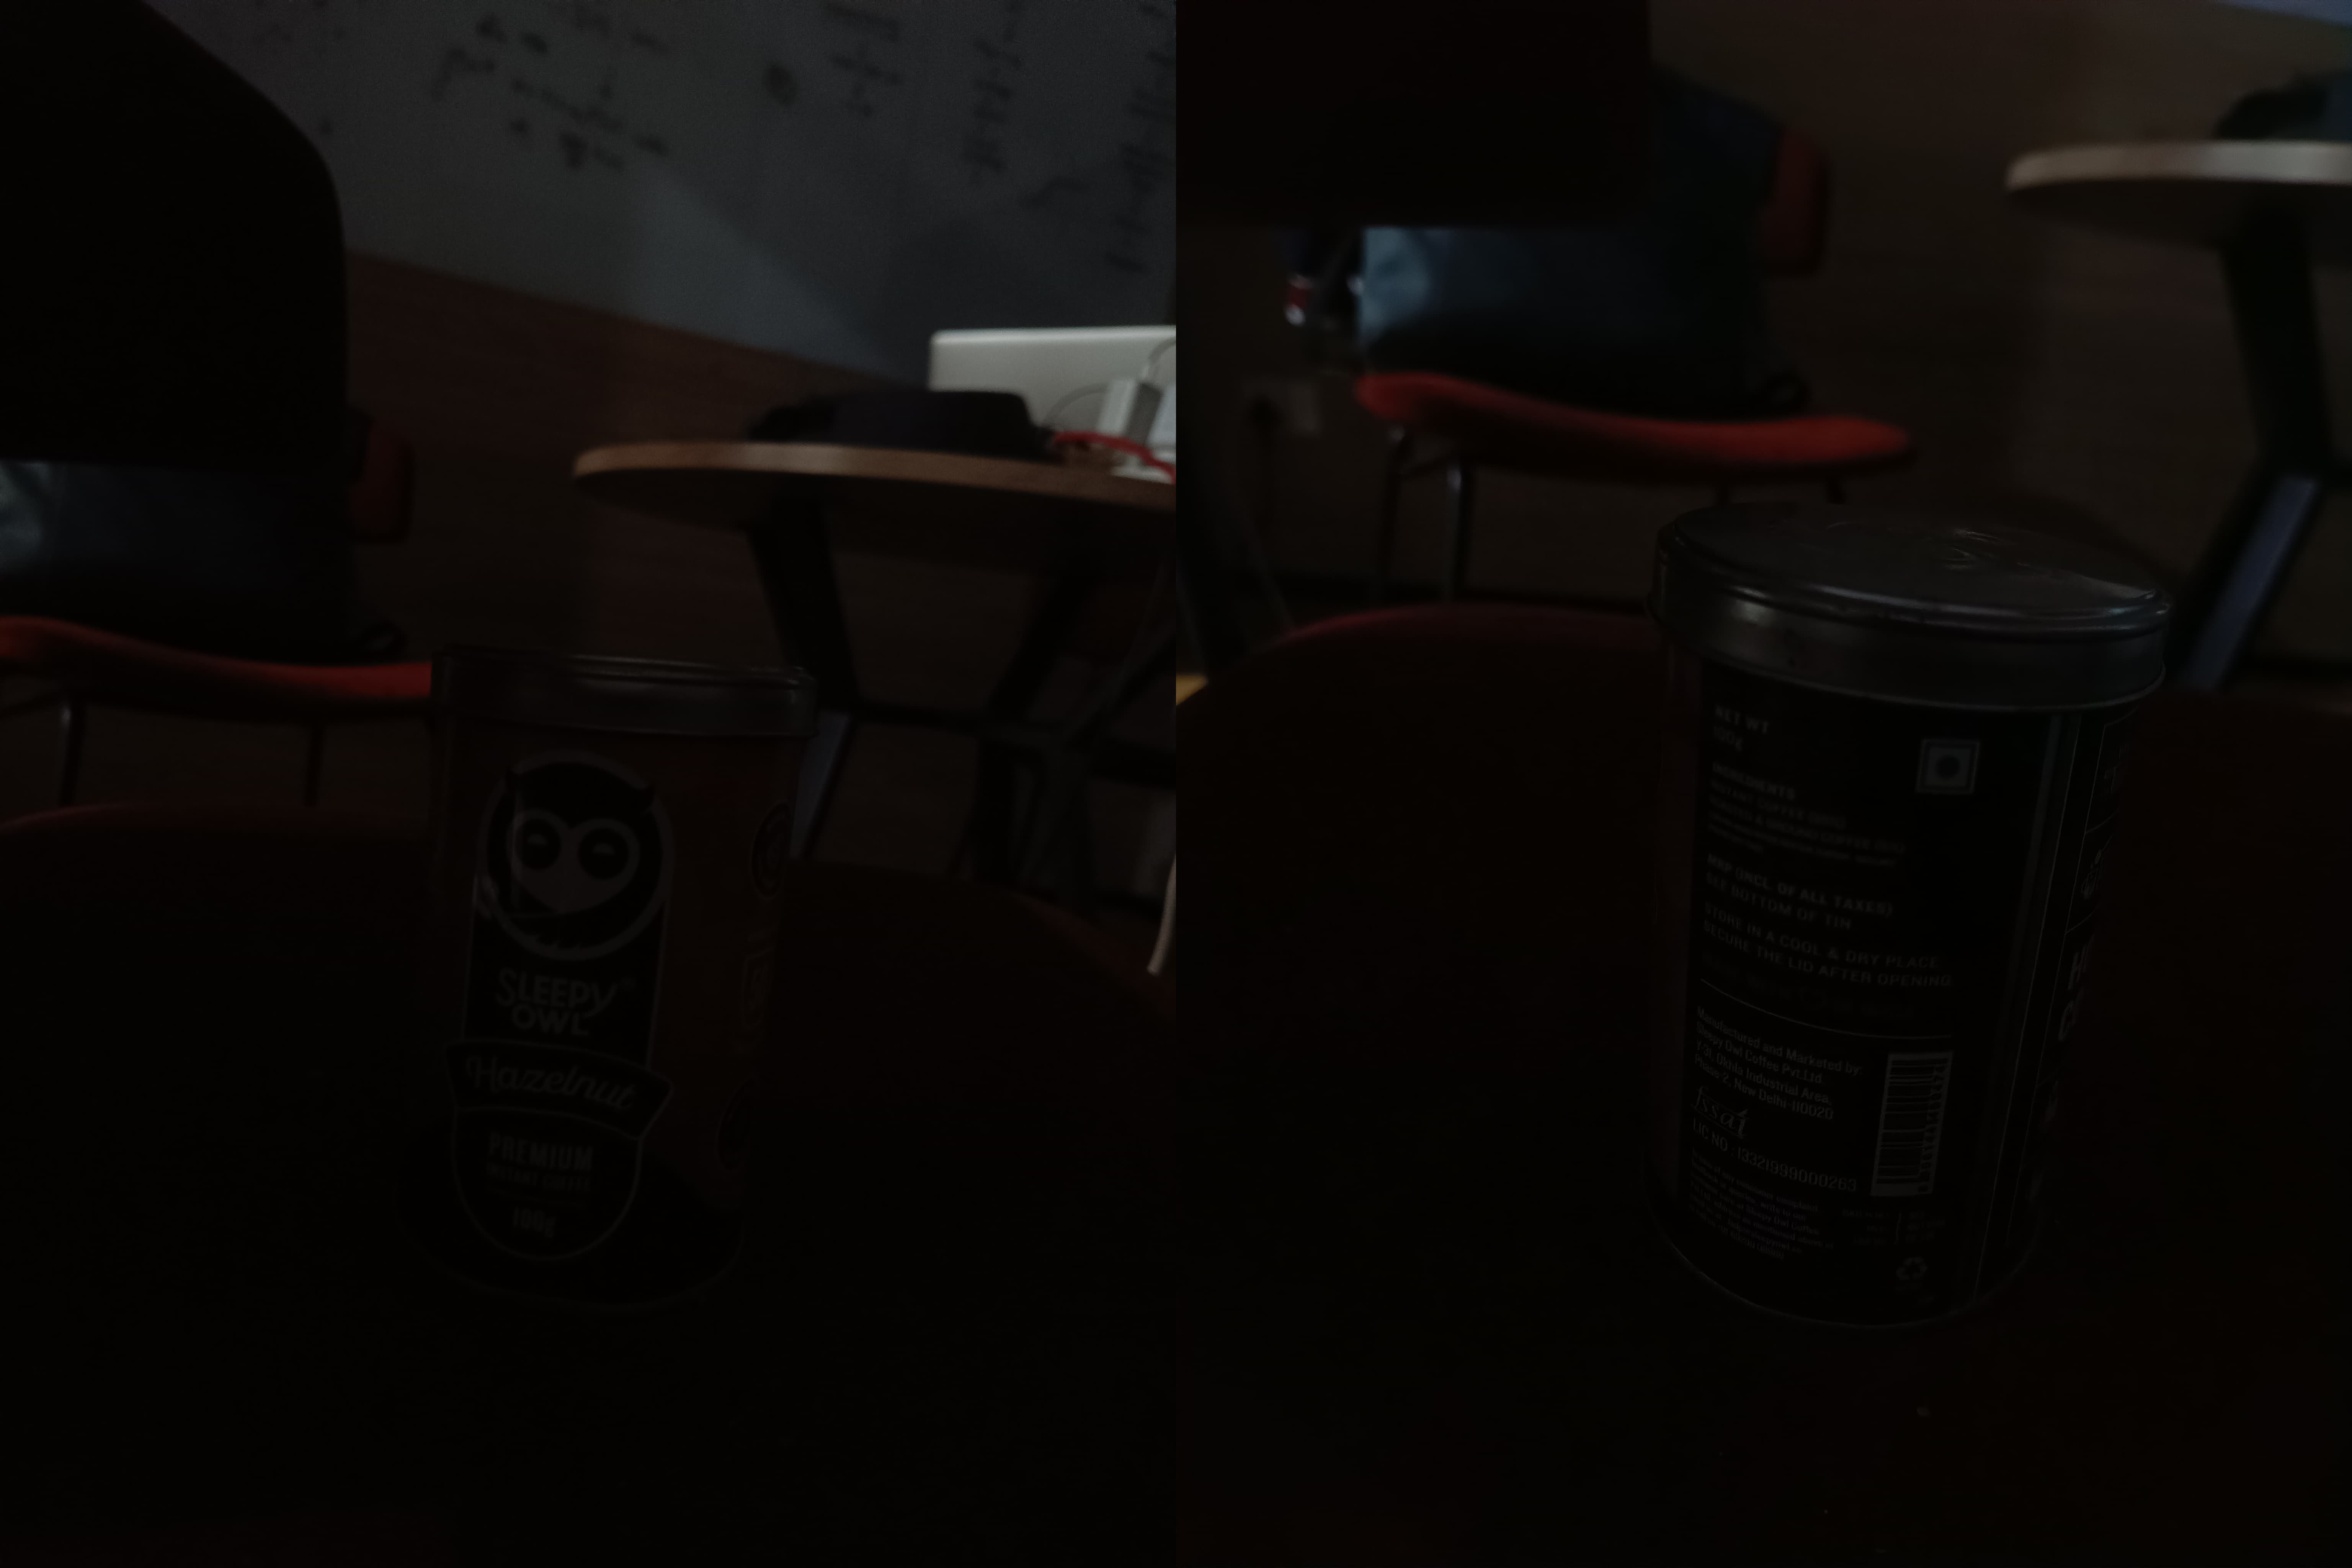

In [6]:
image_path = '/content/drive/MyDrive/night vision dataset-001/night vision dataset/asmcbkjascvkhb.jpg'
image1_path = '/content/drive/MyDrive/night vision dataset-001/night vision dataset/jsbkjacbkldjcbks.dnckdb.jpg'

image = cv2.imread(image_path)
image1 = cv2.imread(image1_path)
images_combined = np.concatenate((image, image1), axis=1)
cv2_imshow(images_combined)

Step 2: Convert the images into a grayscale image

In [7]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

Step 3: Now we find out the histograms of the grayscale image and look for the distribution of intensities.

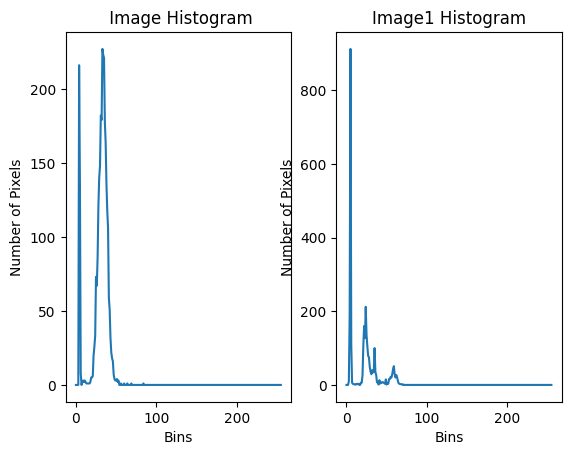

In [8]:
hist_image = cv2.calcHist(gray_image, [0], None, [256], [0, 256])
hist_image1 = cv2.calcHist(gray_image1, [0], None, [256], [0, 256])

plt.subplot(121)
plt.title(" Image Histogram")
plt.xlabel('Bins')
plt.ylabel("Number of Pixels")
plt.plot(hist_image)

plt.subplot(122)
plt.title("Image1 Histogram")
plt.xlabel('Bins')
plt.ylabel("Number of Pixels")
plt.plot(hist_image1)

plt.show()

Step 4: Now we will use a function to equalize the contrast of the grayscale image. This function normalises the brightness and also increases the contrast.

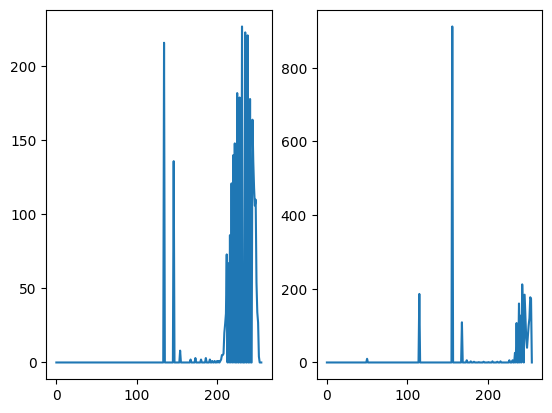

In [9]:
gray_image_eqhist=cv2.equalizeHist(gray_image)
gray_image1_eqhist=cv2.equalizeHist(gray_image1)
hist=cv2.calcHist(gray_image_eqhist,[0],None,[256],[0,256])
hist1=cv2.calcHist(gray_image1_eqhist,[0],None,[256],[0,256])
plt.subplot(121)
plt.plot(hist)
plt.subplot(122)
plt.plot(hist1)
plt.show()

Step 6: Display the Gray Scale Histogram equalized images

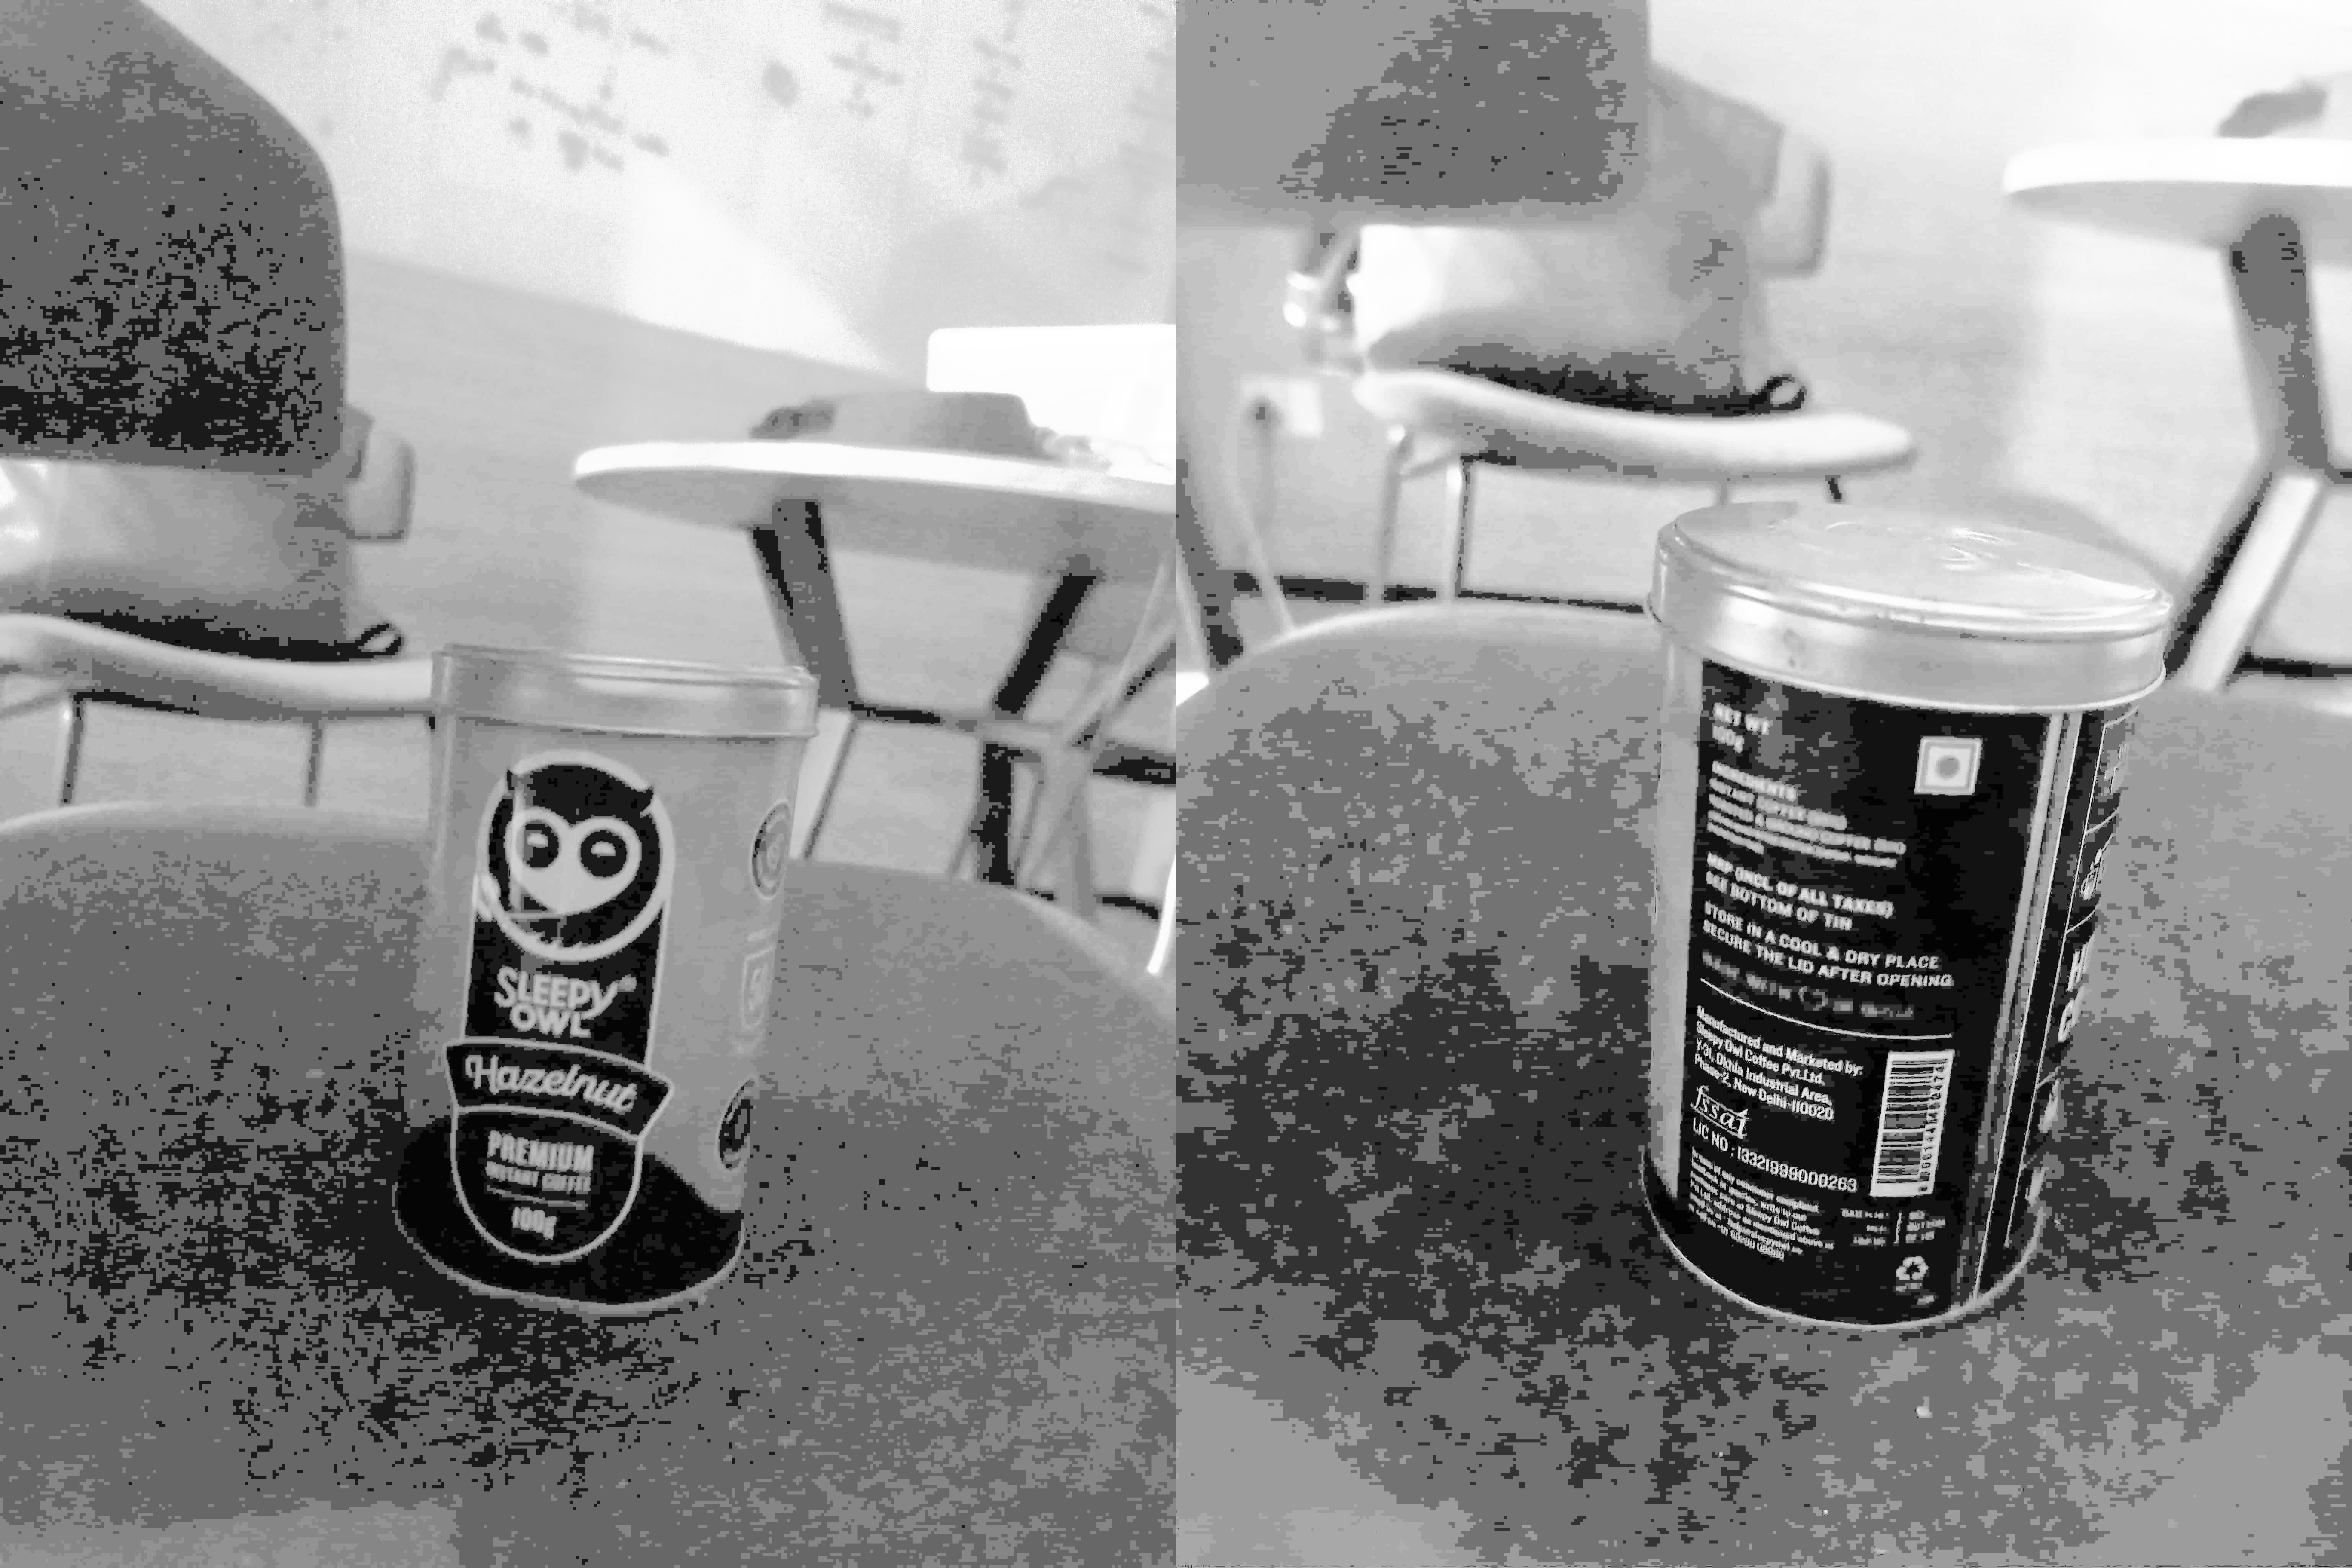

In [10]:
eqhist_images = np.concatenate((gray_image_eqhist, gray_image1_eqhist), axis=1)
cv2_imshow(eqhist_images)

#TRANSMISSION MAPS

In [13]:
# Load the input image
image_path = '/content/IMG20240131213530.jpg'
input_image = cv2.imread(image_path)
print(input_image)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
print(input_image)
I = input_image.astype(np.float64) / 255.0


[[[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [14 16 16]
  [14 16 16]
  [13 15 15]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [13 15 15]
  [14 16 16]
  [13 15 15]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [13 15 15]
  [13 15 15]
  [14 16 16]]

 ...

 [[ 5  5  5]
  [ 5  5  5]
  [ 5  5  5]
  ...
  [ 6  8  8]
  [ 6  8  8]
  [ 6  8  8]]

 [[ 5  5  5]
  [ 5  5  5]
  [ 5  5  5]
  ...
  [ 4  6  6]
  [ 4  6  6]
  [ 4  6  6]]

 [[ 5  5  5]
  [ 5  5  5]
  [ 5  5  5]
  ...
  [ 2  4  4]
  [ 3  5  5]
  [ 3  5  5]]]
[[[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [16 16 14]
  [16 16 14]
  [15 15 13]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [15 15 13]
  [16 16 14]
  [15 15 13]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [15 15 13]
  [15 15 13]
  [16 16 14]]

 ...

 [[ 5  5  5]
  [ 5  5  5]
  [ 5  5  5]
  ...
  [ 8  8  6]
  [ 8  8  6]
  [ 8  8  6]]

 [[ 5  5  5]
  [ 5  5  5]
  [ 5  5  5]
  ...
  [ 6  6  4]
  [ 6  6  4]
  [ 6  6  4]]

 [[ 5  5  5]
  [ 5  5  5]
  [ 5  5  5]
  .

Importing relevant libraries

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy.linalg import inv
from itertools import combinations_with_replacement

Figure out dark and light channel of the image

In [17]:
def get_illumination_channel(I, w):
  '''This function takes two parameters: I, which is an image represented as a NumPy array, and w, which is an
  integer representing the size of a window. The function calculates the dark channel and bright channel of the
  input image I using a sliding window approach.'''
  M, N, _ = I.shape
  padded = np.pad(I, ((int(w/2), int(w/2)), (int(w/2), int(w/2)), (0, 0)), 'edge')
  darkch = np.zeros((M, N))
  brightch = np.zeros((M, N))

  for i, j in np.ndindex(darkch.shape):
      darkch[i, j] = np.min(padded[i:i + w, j:j + w, :]) # dark channel
      brightch[i, j] = np.max(padded[i:i + w, j:j + w, :]) # bright channel

  return darkch, brightch

Estimate the atmospheric light of the input image

In [18]:
def get_atmosphere(I, brightch, p=0.1):
  '''this function estimates the atmospheric light of the input image based on the brightest pixels
  in the bright channel, with the percentage of pixels considered controlled by the parameter p.'''
  M, N = brightch.shape
  flatI = I.reshape(M*N, 3) # reshaping image array
  flatbright = brightch.ravel() #flattening image array

  searchidx = (-flatbright).argsort()[:int(M*N*p)] # sorting and slicing
  A = np.mean(flatI.take(searchidx, axis=0), dtype=np.float64, axis=0)
  return A

Calculate the initial transmission map of an image given the estimated atmospheric light and the bright channel

In [24]:
def get_initial_transmission(A, brightch):
  '''this function computes the initial transmission map of an image, which represents the estimated proportion of light
  transmitted through each pixel, based on the relationship between the bright channel and the estimated atmospheric light.'''
  A_c = np.max(A)
  init_t = (brightch-A_c)/(1.-A_c) # finding initial transmission map
  return (init_t - np.min(init_t))/(np.max(init_t) - np.min(init_t)) # normalized initial transmission map

Compute the corrected transmission map for an image

In [19]:
def get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega, w):
  '''this function refines the initial transmission map by considering both dark channel information and
  differences between bright and dark channel transmission values, aiming to improve the accuracy of
  transmission estimation for image dehazing or related tasks.'''
  im = np.empty(I.shape, I.dtype);
  for ind in range(0, 3):
      im[:, :, ind] = I[:, :, ind] / A[ind] #divide pixel values by atmospheric light
  dark_c, _ = get_illumination_channel(im, w) # dark channel transmission map
  dark_t = 1 - omega*dark_c # corrected dark transmission map
  corrected_t = init_t # initializing corrected transmission map with initial transmission map
  diffch = brightch - darkch # difference between transmission maps

  for i in range(diffch.shape[0]):
      for j in range(diffch.shape[1]):
          if(diffch[i, j] < alpha):
              corrected_t[i, j] = dark_t[i, j] * init_t[i, j]

  return np.abs(corrected_t)

In [26]:
def boxfilter(I, r):
    M, N = I.shape
    dest = np.zeros((M, N))

    sumY = np.cumsum(I, axis=0)
    dest[:r + 1] = sumY[r:2*r + 1] # top r+1 lines
    dest[r + 1:M - r] = sumY[2*r + 1:] - sumY[:M - 2*r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2*r - 1:M - r - 1] # bottom r lines

    sumX = np.cumsum(dest, axis=1)
    dest[:, :r + 1] = sumX[:, r:2*r + 1] # left r+1 columns
    dest[:, r + 1:N - r] = sumX[:, 2*r + 1:] - sumX[:, :N - 2*r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - sumX[:, N - 2*r - 1:N - r - 1] # right r columns

    return dest

Implement a guided Feature

In [20]:
def guided_filter(I, p, r=15, eps=1e-3):
  '''refines the filtering operation by taking into account the structure of a guidance image p to guide
  the filtering process, resulting in an output image q that preserves edges and fine details while reducing
  noise and smoothing the image.'''
  M, N = p.shape
  base = boxfilter(np.ones((M, N)), r)

  R, G, B = 0, 1, 2  # Index for convenience

  means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
  mean_p = boxfilter(p, r) / base

  means_IP = [boxfilter(I[:, :, i]*p, r) / base for i in range(3)]

  covIP = [means_IP[i] - means[i]*mean_p for i in range(3)]

  var = defaultdict(dict)
  for i, j in combinations_with_replacement(range(3), 2):
      var[i][j] = boxfilter(I[:, :, i]*I[:, :, j], r) / base - means[i]*means[j]

  a = np.zeros((M, N, 3))
  for y, x in np.ndindex(M, N):
      Sigma = np.array([[var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                        [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                        [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]]])
      cov = np.array([c[y, x] for c in covIP])
      a[y, x] = np.dot(cov, inv(Sigma + eps*np.eye(3)))

  b = mean_p - a[:, :, R]*means[R] - a[:, :, G]*means[G] - a[:, :, B]*means[B]

  q = (boxfilter(a[:, :, R], r)*I[:, :, R] + boxfilter(a[:, :, G], r)*I[:, :, G] + boxfilter(a[:, :, B], r)*I[:, :, B] + boxfilter(b, r)) / base

  return q

Compute the final dehazed image

In [21]:
def get_final_image(I, A, refined_t, tmin):
  ''' this function applies the dehazing process to the original image I using the estimated atmospheric
  light A and the refined transmission map refined_t, ensuring that the resulting image is properly scaled
  and within the range [0, 1].'''
  refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None], (refined_t.shape[0], refined_t.shape[1], 3))
  J = (I-A) / (np.where(refined_t_broadcasted < tmin, tmin, refined_t_broadcasted)) + A

  return (J - np.min(J))/(np.max(J) - np.min(J))

In [22]:
# Load the input image
image_path = '/content/IMG20240131213530.jpg'
input_image = cv2.imread(image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
I = input_image.astype(np.float64) / 255.0

# Parameters for the image enhancement
w = 15
p = 0.1
alpha = 0.1
omega = 0.95
r = 15
eps = 1e-3
tmin = 0.1

# Get dark and bright channels
darkch, brightch = get_illumination_channel(I, w)

# Visualize dark channel
plt.figure(figsize=(8, 4))
plt.subplot

<function matplotlib.pyplot.subplot(*args, **kwargs)>

<Figure size 800x400 with 0 Axes>

Visualize all the images

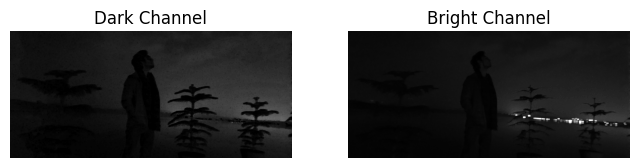

In [28]:
# Visualize dark channel
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(darkch, cmap='gray')
plt.title('Dark Channel')
plt.axis('off')

# Visualize bright channel
plt.subplot(1, 2, 2)
plt.imshow(brightch, cmap='gray')
plt.title('Bright Channel')
plt.axis('off')
plt.show()

In [29]:
# Estimate atmospheric light
A = get_atmosphere(I, brightch, p)

# Visualize atmospheric light
print("Estimated Atmospheric Light (A):", A)

Estimated Atmospheric Light (A): [0.13906241 0.14759742 0.11694112]


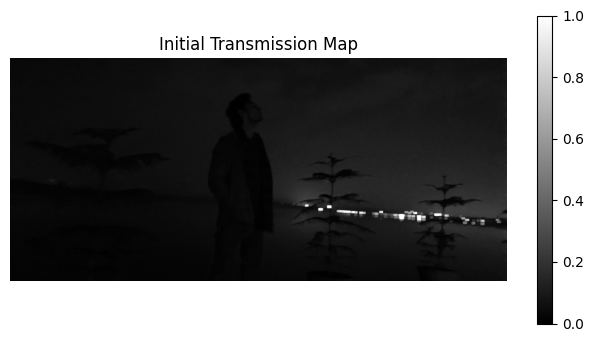

In [30]:
# Obtain initial transmission
init_t = get_initial_transmission(A, brightch)

# Visualize initial transmission
plt.figure(figsize=(8, 4))
plt.imshow(init_t, cmap='gray')
plt.title('Initial Transmission Map')
plt.axis('off')
plt.colorbar()
plt.show()

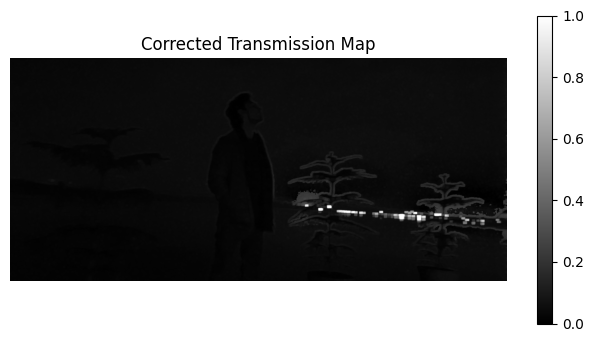

In [31]:
# Get corrected transmission
corrected_t = get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega, w)

# Visualize corrected transmission
plt.figure(figsize=(8, 4))
plt.imshow(corrected_t, cmap='gray')
plt.title('Corrected Transmission Map')
plt.axis('off')
plt.colorbar()
plt.show()

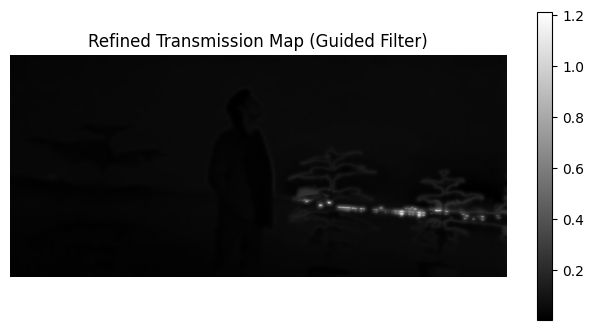

In [32]:
# Apply guided filter to refine transmission
refined_t_guided = guided_filter(I, corrected_t, r, eps)

# Visualize refined transmission using guided filter
plt.figure(figsize=(8, 4))
plt.imshow(refined_t_guided, cmap='gray')
plt.title('Refined Transmission Map (Guided Filter)')
plt.axis('off')
plt.colorbar()
plt.show()

In [33]:
# Get the final enhanced image
enhanced_image = get_final_image(I, A, refined_t_guided, tmin)

# Visualize the input and enhanced images
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

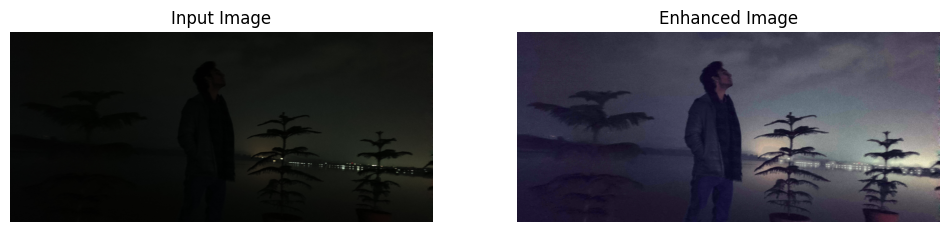

In [36]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plot the input image
plt.subplot(1, 2, 1)
plt.imshow(I)
plt.title('Input Image')
plt.axis('off')

# Plot the enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

####Reference:

For certain codes, areas that I hadn't covered as of now, I used the following git rep that helped me structure this project better, the link to which is attached here

https://github.com/ba-san/Python-image-enhancement-with-bright-dark-prior/blob/master/src/guidedfilter.py